In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
from matplotlib.colors import ListedColormap
from matplotlib import colors as COL
from scripts.simulate_data import generate_linescan

In [2]:
plt.rcParams['figure.figsize'] = 20, 6
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 30

Presettings: We generate a linescanning dataset with:
1. 8 measurements (4 measurements higher bold response, 4 measurements lower bold response)
2. 10 repetitions a 30 seconds (10s pause - 10 seconds stimulus - 10 seconds pause)
3. sampling rate (SR) = 20

In [3]:
max_bold_change_first = 2.
max_bold_change_first = 5.

negative_bold_chage = -.3

repeats = 10

xt = np.linspace(- 5, 5, 200)


X = np.concatenate([generate_linescan(4, max_bold_change=2, repeats=repeats,
                                      sampling_rate=20, negative_bold_chage=negative_bold_chage),
                    generate_linescan(4, max_bold_change=5, repeats=repeats,
                                      sampling_rate=20, negative_bold_chage=negative_bold_chage)], axis=0)
print(X.shape)

(8, 128, 6000)


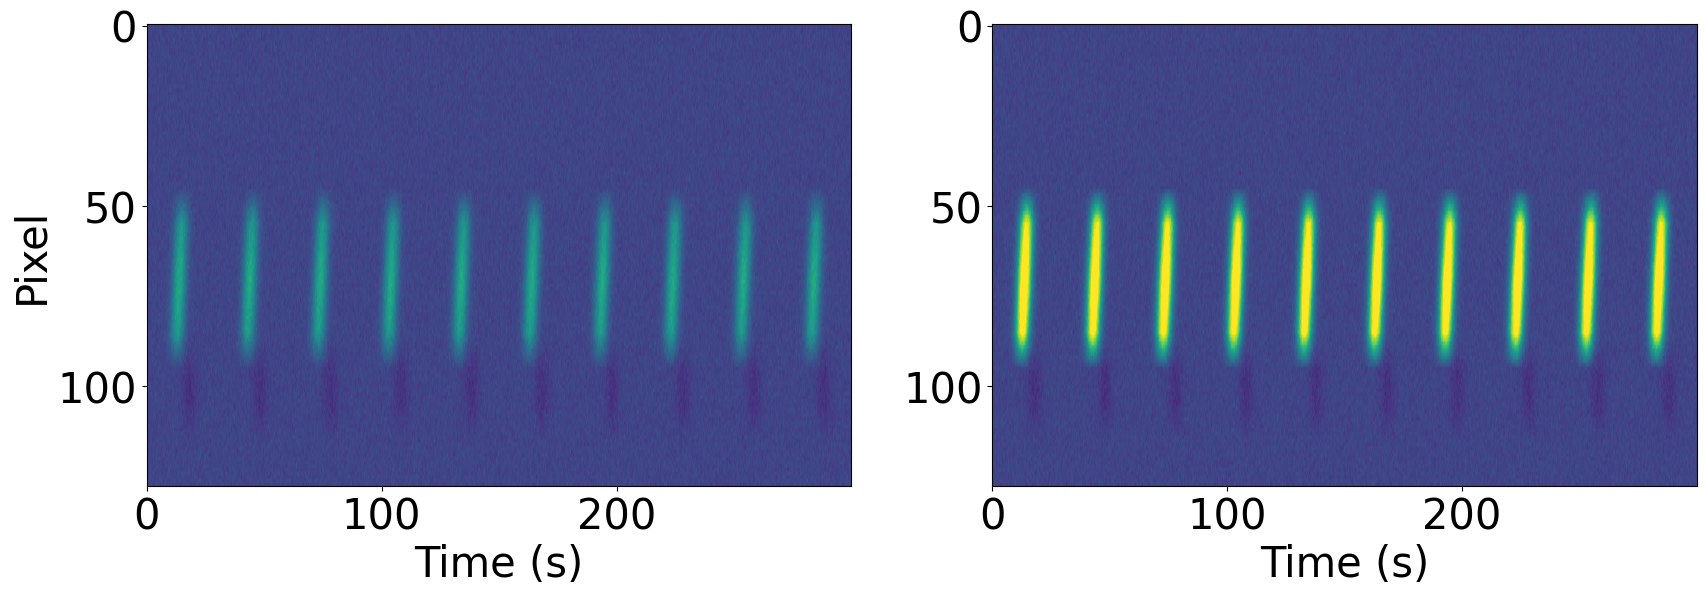

In [4]:
plt.subplot(121)
plt.imshow(np.mean(X[:4], axis=0), aspect="auto", vmin=0, vmax=np.mean(X, axis=0).max())
plt.xticks(np.arange(np.shape(X)[2])[::2000], np.arange(np.shape(X)[2])[::2000]//20)
plt.ylabel("Pixel")
plt.xlabel("Time (s)")
plt.subplot(122)
plt.imshow(np.mean(X[4:], axis=0), aspect="auto", vmin=0, vmax=np.mean(X, axis=0).max())
plt.xticks(np.arange(np.shape(X)[2])[::2000], np.arange(np.shape(X)[2])[::2000]//20)
plt.xlabel("Time (s)")
plt.show()

# Rise Clustering

In [5]:
# store all signals in a clusterable 2D-Array
T = []
for q in range(len(X)):
    # iterate over all measurements
    for t in range(0, X.shape[1]):
        # iterate over all pixels
        averaged_signal = sum([np.mean(X[q, t:t+1, 600*i:600*(i+1)] ,
                                       axis=0)
                               for i in range(0, repeats)])[:]/repeats
        T.append(averaged_signal.reshape(1, -1))
T = np.concatenate(T, axis=0)
stimtype = np.array([0]*128*4 + [1]*128*4)

In [6]:
n_classes = 3
start, end = 200, 400  # interval to search the stimulus response

In [7]:
distmat = (cdist(T[:, start:end], T[:, start:end], metric="correlation"))

In [8]:
# first correlation clustering to focus on the positive signals
cluster = AgglomerativeClustering(n_clusters=n_classes).fit_predict(distmat)

/Users/lucasplagwitz/miniforge3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [9]:
means = [np.mean(T[cluster==i]) for i in range(3)]
main_one = np.argmax([np.mean(T[cluster == i]) for i in range(3)])
pos_clu = cluster[(cluster == np.argmax(means))]  # | (cluster==0) | (cluster==3)

In [10]:
X_dtw = np.zeros((len(pos_clu), len(pos_clu)))

bound = 50
TT = T.copy()
argmxs = []
t50s = []
t10s = []
for i in range(len(T)):
    if (cluster[i] == np.argmax(means)): #and np.max(TT[i, 240:280]) > 0.001:

        TT[i] = TT[i] - np.mean(TT[i, 180:200])
        TT[i] = TT[i] / np.max(TT[i, 200:400])
        argmxs.append(np.argmax(TT[i]))
        t50s.append(np.where(TT[i] > .5)[0][0])
        t10s.append(np.where(TT[i, 205:] > .1)[0][0] + 205)
    else:
        cluster[i] = 0 if np.argmax(means) != 0 else 1
        TT[i] = 0 * TT[i]
        argmxs.append(-1)
        t50s.append(-1)
        t10s.append(-1)
argmxs = np.array(argmxs)
t50s = np.array(t50s)
t10s = np.array(t10s)

In [11]:
idxs = (np.max(T[:, 200:400], axis=1) > bound)
idxs = (cluster == np.argmax(means))
pos_clu = cluster[idxs]
X_dtw = np.zeros((len(np.where(idxs == True)[0]), len(np.where(idxs == True)[0])))
X_dtw.shape
np.shape(X_dtw)

n_classes = 3
from sklearn.cluster import AgglomerativeClustering

start, end = 200, 400
cluster_dtw = AgglomerativeClustering(n_clusters=n_classes).fit_predict(
    TT[idxs][:, 220:260]
)

In [12]:
import pandas as pd
pd.Series(cluster_dtw).value_counts()

0    200
2     94
1     92
dtype: int64

In [13]:
cluster_dtw_all = np.zeros(np.shape(cluster)) + 4

cluster_dtw_all[idxs] = cluster_dtw

In [14]:
colors = np.array(["red", "orange", "purple",  "white", "white"])
allo = {}
for i in np.unique(cluster_dtw):
    allo[i] = np.max(np.mean(np.abs(T[cluster_dtw_all==i]), axis=0))
order = list({k: v for k, v in sorted(allo.items(), key=lambda item: item[1], reverse=True)}.keys())
#colors = colors[order]
order.append(4)
cluster2 = cluster.copy()

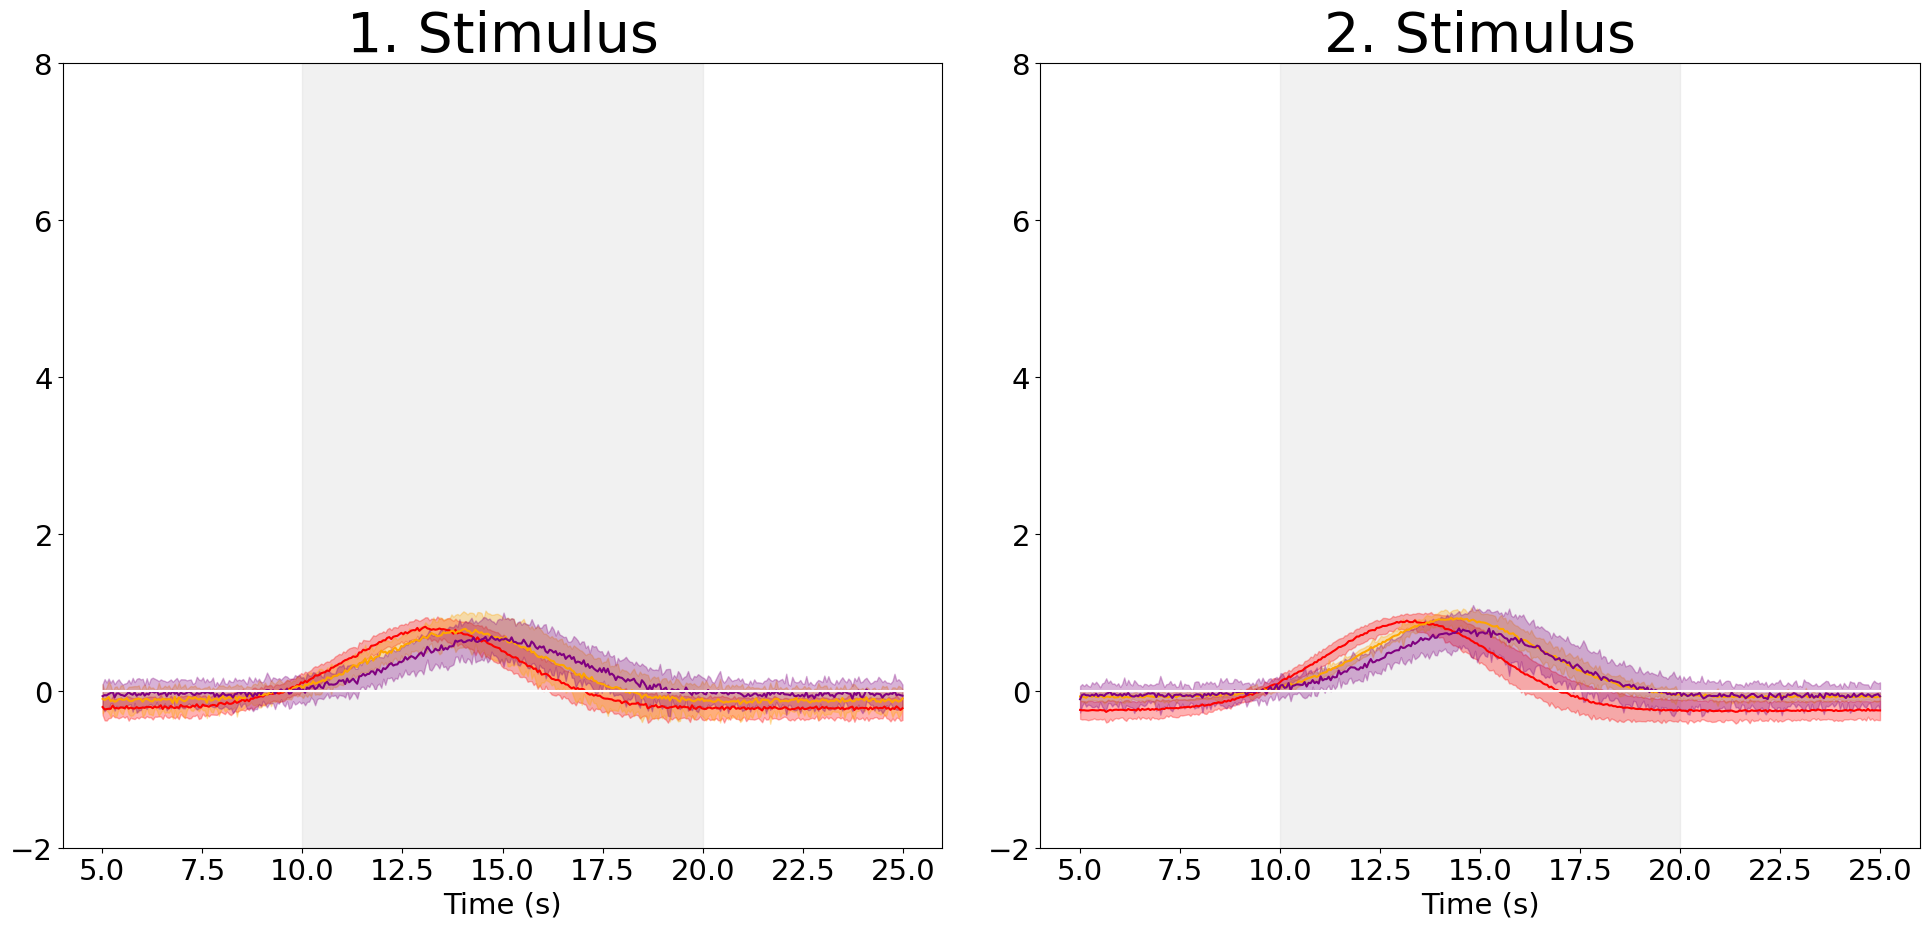

In [15]:
plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['xtick.labelsize'] = 21
plt.rcParams['ytick.labelsize'] = 21
labels = ["1. Stimulus", "2. Stimulus"]
for k in range(2):
    # iterate over two types of stimulus
    plt.subplot(121+k)
    plt.axvspan(10, 20, alpha=0.3, color='lightgrey')
    for i, cl in enumerate(order): # n_classes
        plt.title(labels[k], fontsize=40)
        if not set(np.where(cluster_dtw_all==cl)[0]).intersection(
                set(np.where(np.array(stimtype)==k)[0])):
            continue
        v = np.mean(TT[list(set(np.where(cluster_dtw_all==cl)[0]).intersection(
            set(np.where(np.array(stimtype)==k)[0])))], axis=0)

        v_min = np.min(TT[list(set(np.where(cluster_dtw_all==cl)[0]).intersection(
            set(np.where(np.array(stimtype)==k)[0])))], axis=0)
        v_max = np.max(TT[list(set(np.where(cluster_dtw_all==cl)[0]).intersection(
            set(np.where(np.array(stimtype)==k)[0])))], axis=0)
        v_std = np.std(TT[list(set(np.where(cluster_dtw_all==cl)[0]).intersection(
            set(np.where(np.array(stimtype)==k)[0])))], axis=0)

        v = v[:]

        plt.plot(np.linspace(0, 30, 600)[100:500], v[100:500], c=colors[i], alpha=1)
        plt.fill_between(np.linspace(0, 30, 600)[100:500], (v-v_std)[100:500], (v+v_std)[100:500], alpha=0.3, color=colors[i])
    plt.ylim([-2, 8])
    plt.xlabel("Time (s)", fontsize=21)
    plt.vlines(np.linspace(0, 30, 600)[start], np.min(T)*200, np.max(T)*200, colors="black", linestyles="--", label="interval")
    plt.vlines(np.linspace(0, 30, 600)[end], np.min(T)*200, np.max(T)*200, colors="black", linestyles="--")
plt.tight_layout()

8


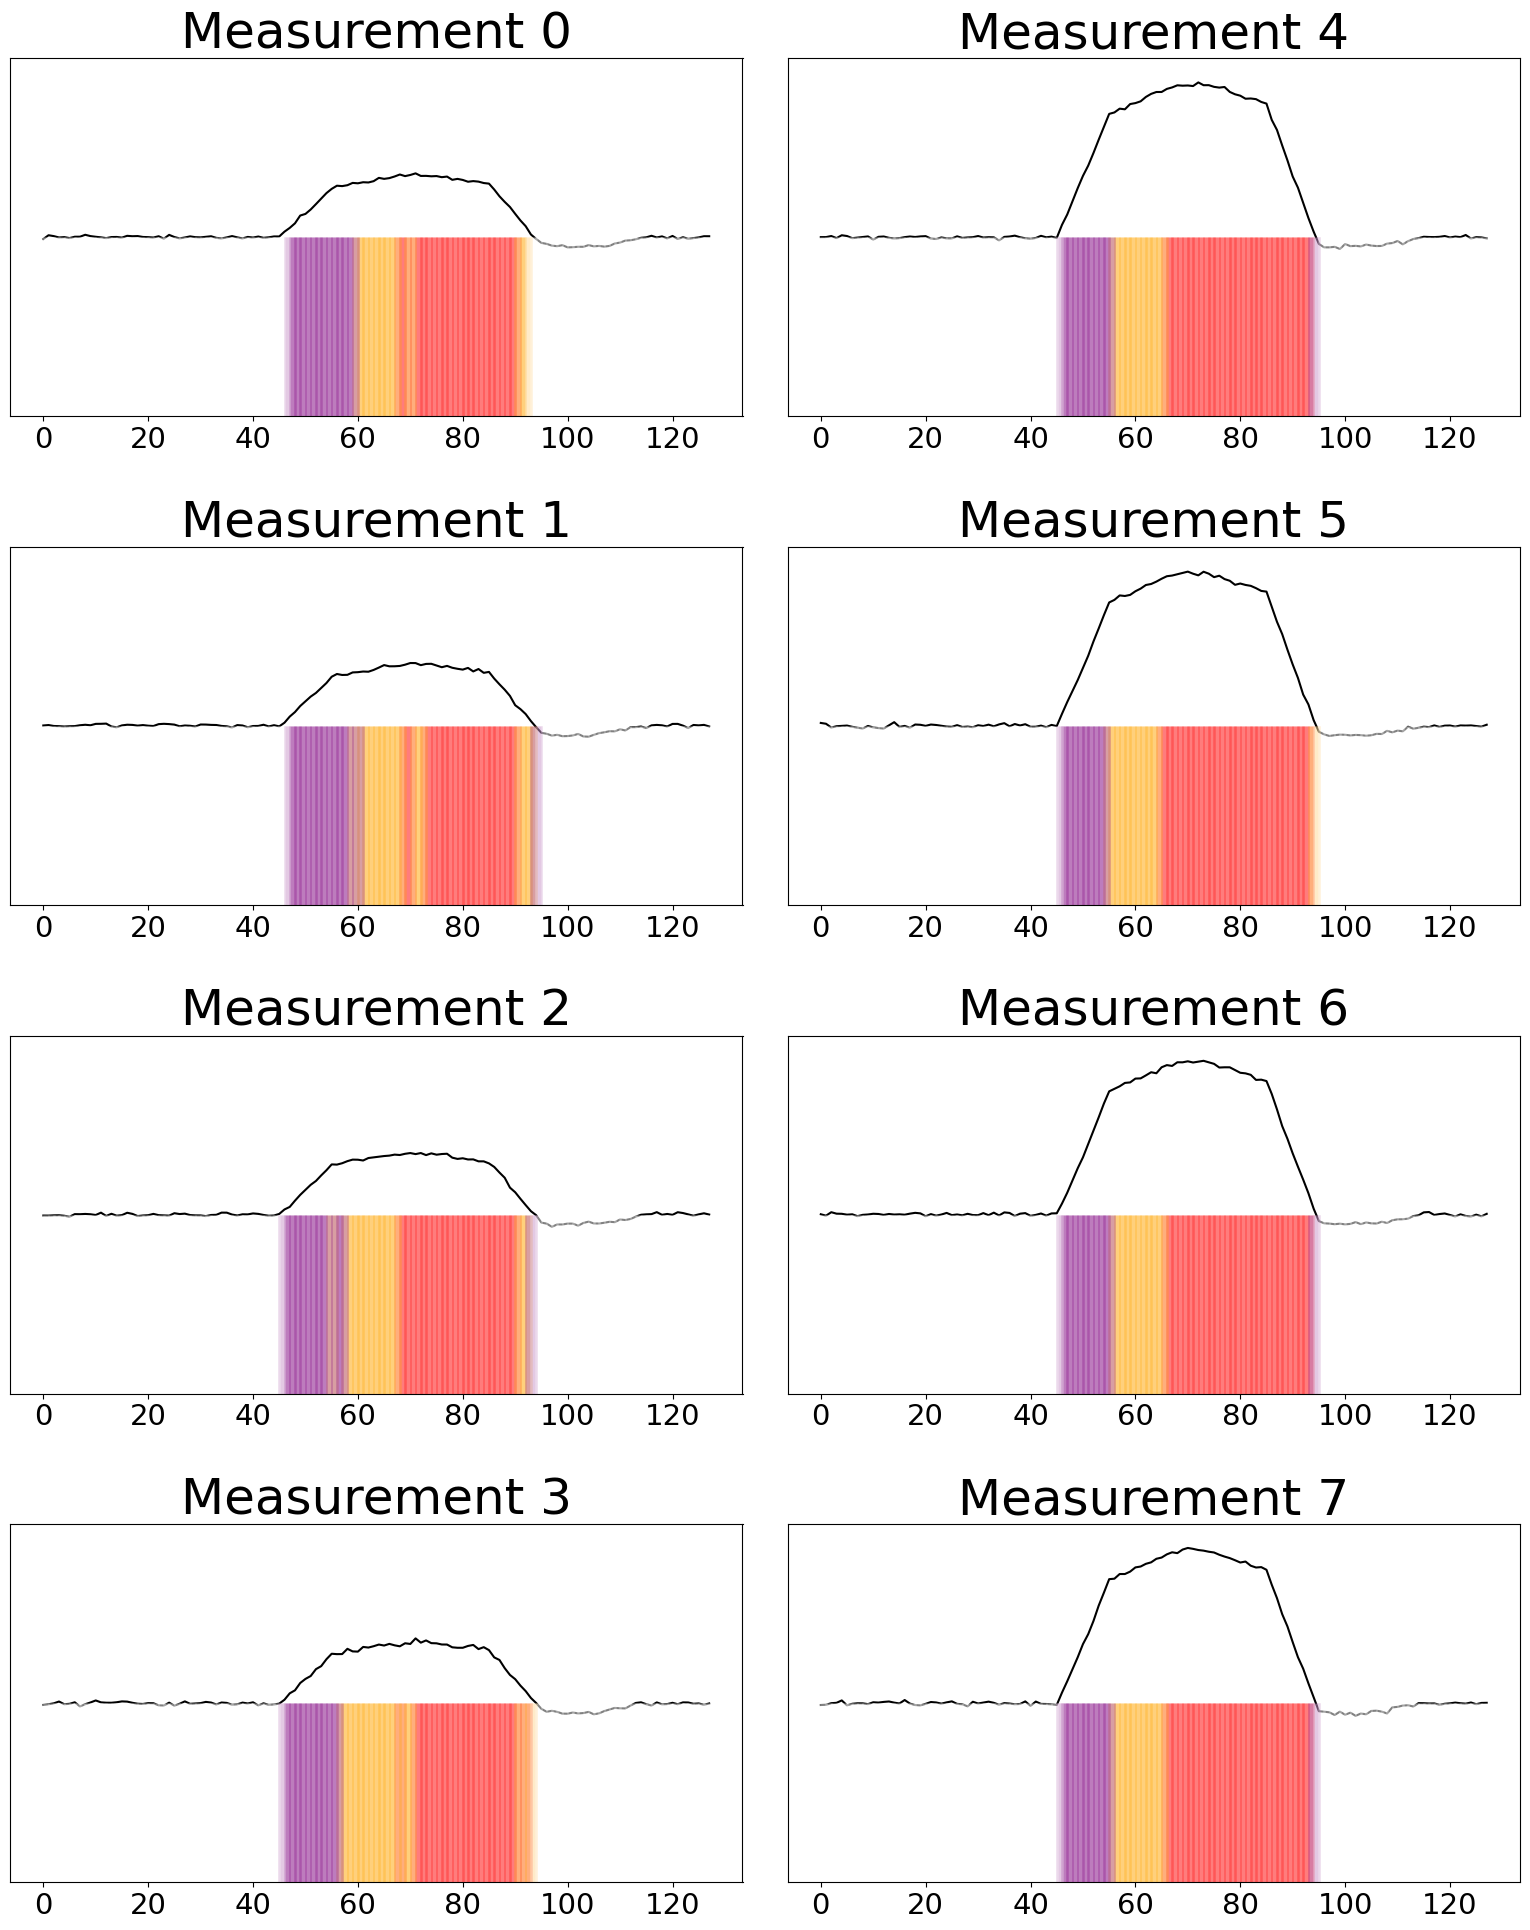

In [16]:
plt.rcParams['figure.figsize'] = 16, 20
print(len(X))
oFig1 = plt.figure(1)
cl_el = []
cl_op = []

ofs = 60

nx_op = 2
nx_el = 1

el_mean = np.empty((0, ofs*2+8))
op_mean = np.empty((0, ofs*2+8))
colcol = [None]*5

snr_optos = []
snr_elecs = []
stim = [0]*4 + [1]*4

argmaxs = []
for t in range(len(X)):
    argmax = 60 #np.argmax(np.mean(X[t], axis=1))
    #argfastmax = np.max(np.where(np.mean(X[t], axis=1)[:argmax+10] > .95*(np.mean(X[t], axis=1))[argmax])[0])
    #dip = np.min(np.where(np.diff(np.mean(X[t], axis=1))[argfastmax+4:]>0)) +ofs
    #argmax = argfastmax+dip-ofs-6

    if stim[t] == 0:
        a = sum([
                X[t, :, 600*i:600*(i+1)]
            for i in range(0, repeats)])[:]/repeats

        #a /= np.mean(a[:, 100:200], axis=1).reshape((-1, 1))
        #a -= 1

        snr_elecs.append((np.mean(
            (a[argmax-14:argmax+14, 100:280])[:]
        #                          )
        , axis=0)))


    else:
        a = sum([
                X[t, :, 600*i:600*(i+1)]
            for i in range(0, repeats)])[:]/repeats
        tmp = np.mean(a[:, 100:200], axis=1).reshape((-1, 1))
        a /= np.mean(a[:, 100:200], axis=1).reshape((-1, 1))

        a -= 1

        snr_optos.append((np.mean(
            (a[argmax-14:argmax+14, 100:280])[:]
        , axis=0)))


    argmaxs.append(argmax)
    if stim[t] == 0:
        oFig1.add_subplot(len(X)//2, 2, nx_el)
        nx_el += 2
        cl_el.extend(cluster_dtw_all[128*t:(t+1)*128])
        el_mean = np.concatenate([el_mean, cluster_dtw_all[128*t+argmax-ofs:128*t+argmax+ofs+8].reshape((1, -1))], axis=0)
    else:
        oFig1.add_subplot(len(X)//2, 2, nx_op)
        nx_op += 2
        cl_op.extend(cluster_dtw_all[128*t:(t+1)*128])
        op_mean = np.concatenate([op_mean, cluster_dtw_all[128*t+argmax-ofs:128*t+argmax+ofs+8].reshape((1, -1))], axis=0)
    plt.plot(np.mean(X[t], axis=1)#[argmax-ofs: argmax+ofs+8]
             , c="black")
    for i, cl in enumerate(order):
        colcol[cl] = colors[i]
        idx = np.where(cluster_dtw_all==cl)[0]
        for j in range(1):
            if stim[t] == 0:
                plt.vlines((idx[np.logical_and((idx>=128*t+argmax-ofs),
                                               (idx<128*t+argmax+ofs+8))]-128*t)-argmax+ofs, 0, 1, colors=colors[i], alpha=.3, linewidth=9)
            else:
                plt.vlines((idx[np.logical_and((idx>=128*t+argmax-ofs),
                                               (idx<128*t+argmax+ofs+8))]-128*t)-argmax+ofs, 0, 1, colors=colors[i], alpha=.3, linewidth=9)
    plt.title(f"Measurement {t}")
    plt.ylim(0, 2)
    plt.yticks([])
plt.tight_layout()

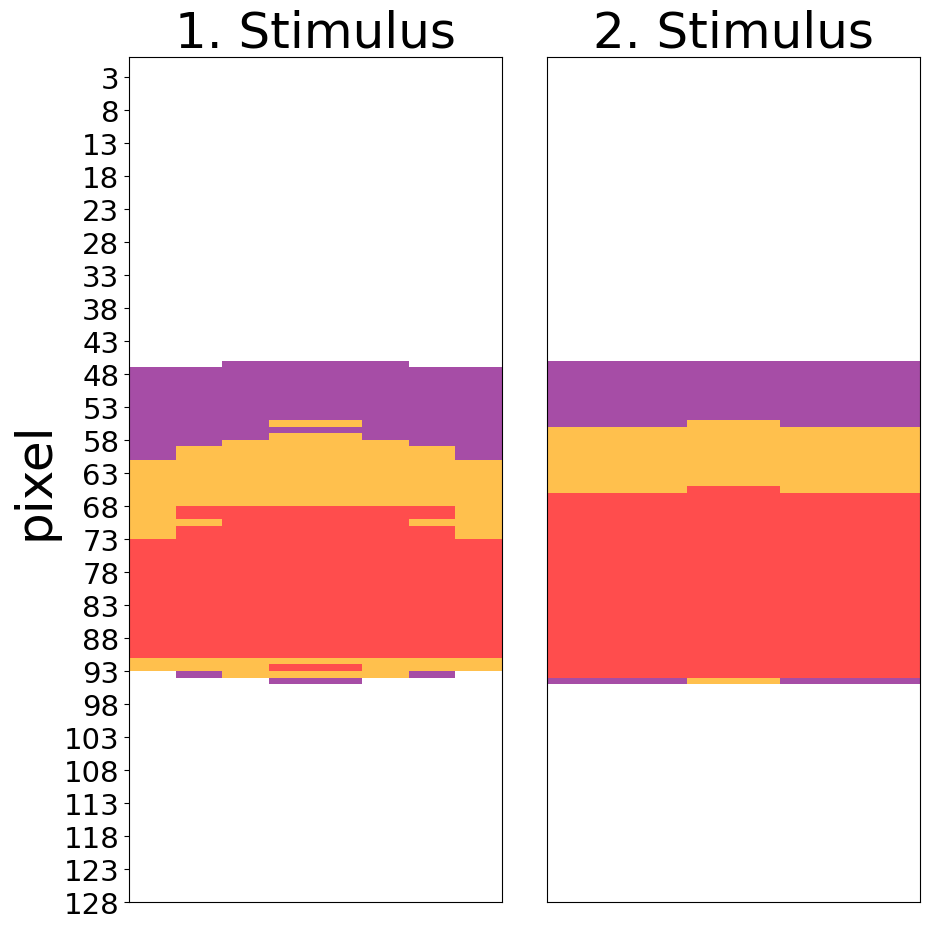

In [17]:
fontsize = 26
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['figure.figsize'] = 10, 10
cmap = COL.ListedColormap(["white"] + colors[:4][::-1][1:4].tolist())

my_cmap = cmap(np.arange(cmap.N))
BG = np.asarray([1., 1., 1.,])
for i in range(cmap.N):
    my_cmap[i,:-1] = my_cmap[i,:-1] * 0.7 + BG * (1.-.7)
my_cmap = ListedColormap(my_cmap)
cmap = my_cmap

bounds=[-0.1, .4, 1.1,2.1, 3.1]
norm = COL.BoundaryNorm(bounds, cmap.N)

copy_idx = np.zeros(np.shape(op_mean))
for i, val in enumerate(order[::-1]):
    copy_idx[el_mean==val] = i

#for i in range(9):
copy_idx = -np.sort(-copy_idx, axis=0)

plt.subplot(121)
plt.title("1. Stimulus", fontsize=fontsize+10)
plt.pcolormesh(np.concatenate([np.flip(np.rot90(copy_idx), axis=1),
                               np.rot90(copy_idx)], axis=1),
               cmap=cmap, norm=norm)

# -> mark cortex if you want
#plt.axhspan(68, 29+8+7+4+6+2, alpha=0.7, color='white')
#plt.axhspan(29-1, 0, alpha=0.7, color='white')

#bound = np.array([29-1, 29+8-1, 29+8+7-1, 29+8+7+5-1, 29+8+7+5+6-1, 29+8+7+5+6+2-1])
#plt.hlines(bound, 0, 4, linestyles="--", colors="black")

plt.ylabel("pixel", fontsize=fontsize+10)
plt.xticks([])

# mark Corpus Calosum (CC) if you want
#plt.yticks(np.arange(0, len(np.rot90(copy_idx)))[::4]-0.5,
#           [x if x != 29 else "CC" for x in len(np.rot90(copy_idx))- np.arange(0, len(np.rot90(copy_idx)))[::4]-11])
plt.yticks(np.arange(0, len(np.rot90(copy_idx)))[::5],
           128-np.arange(0, len(np.rot90(copy_idx)))[::5])


plt.subplot(122)
plt.title("2. Stimulus", fontsize=fontsize+10)
copy_idx = np.zeros(np.shape(op_mean))
for i, val in enumerate(order[::-1]):
    copy_idx[op_mean==val] = i

copy_idx = -np.sort(-copy_idx, axis=0)
plt.pcolormesh(np.concatenate([np.flip(np.rot90(copy_idx), axis=1), np.rot90(copy_idx)], axis=1), cmap=cmap, norm=norm)

# -> mark cortex if you want
# plt.axhspan(68, 29+8+7+4+6+2, alpha=0.7, color='white')
# plt.axhspan(29-1, 0, alpha=0.7, color='white')

#bound = np.array([29-1, 29+8-1, 29+8+7-1, 29+8+7+5-1, 29+8+7+5+6-1, 29+8+7+5+6+2-1])
#plt.hlines(bound, 0, 4, linestyles="--", colors="black")

plt.xticks([])
plt.yticks([])
plt.tight_layout()